<a href="https://colab.research.google.com/github/master-PA/HealthSnap/blob/main/healthsnap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import linregress

In [ ]:
num_users = 500
num_days = 40

In [ ]:
symptoms = [
    "fever", "cough", "sore_throat", "runny_nose", "breath_shortness", "fatigue",
    "headache", "body_pain", "appetite_loss", "nausea", "stomach_pain",
    "sleep_quality", "mood_swings", "anxiety", "irritability", "concentration_loss"
]

resp_cluster = ["fever", "cough", "sore_throat", "runny_nose", "breath_shortness"]
digestive_cluster = ["nausea", "stomach_pain", "appetite_loss"]
mental_cluster = ["mood_swings", "anxiety", "irritability", "concentration_loss", "sleep_quality"]
body_cluster = ["body_pain", "fatigue", "headache"]

clusters = [resp_cluster, digestive_cluster, mental_cluster, body_cluster]
labels = ["stable", "improving", "needs_attention"]

all_rows = []

In [ ]:
def generate_symptom_series(label):

    base = np.random.uniform(0, 2, len(symptoms))
    daily = np.zeros((num_days, len(symptoms)))


    daily[0] = base
    for i in range(1, num_days):
        drift = np.random.normal(0, 0.2, len(symptoms))
        daily[i] = np.clip(daily[i-1] + drift, 0, 10)


    for _ in range(random.randint(0, 2)):
        start = random.randint(5, num_days - 8)
        dur = random.randint(3, 7)
        cluster = random.choice(clusters)
        indices = [symptoms.index(s) for s in cluster]
        amp = np.random.uniform(2.0, 4.0)
        for d in range(start, start + dur):
            daily[d, indices] += amp
            daily[d] = np.clip(daily[d], 0, 10)


    trend = np.linspace(0, 0, num_days)
    if label == "improving":
        trend = np.linspace(1.5, -1.5, num_days)
    elif label == "needs_attention":
        trend = np.linspace(-1.5, 1.5, num_days)

    daily += trend[:, None]
    daily = np.clip(daily + np.random.normal(0, 0.3, daily.shape), 0, 10)
    return daily

In [ ]:
for user_id in range(1, num_users + 1):
    label = random.choice(labels)  # balanced random label
    daily_data = generate_symptom_series(label)

    age = random.randint(18, 65)
    gender = random.choice(["male", "female"])
    lifestyle = random.choice(["active", "moderate", "sedentary"])

    for day in range(num_days):
        row = {
            "user_id": user_id,
            "day": day + 1,
            "age": age,
            "gender": gender,
            "lifestyle": lifestyle,
            "label": label
        }
        row.update({symptoms[i]: round(float(daily_data[day, i]), 2) for i in range(len(symptoms))})
        all_rows.append(row)





✅ Dataset generated and saved as 'improved_symptom_pattern_dataset.csv'
Label distribution:
 label
improving          6440
needs_attention    6440
stable             6440
Name: count, dtype: int64
Shape: (19320, 22)


In [ ]:

df = pd.DataFrame(all_rows)

# ensure balanced class distribution
min_class_count = df["label"].value_counts().min()
balanced_df = pd.concat([
    df[df["label"] == lbl].sample(min_class_count, random_state=42)
    for lbl in labels
])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)



In [ ]:
balanced_df.to_csv("improved_symptom_pattern_dataset.csv", index=False)
print("✅ Dataset generated and saved as 'improved_symptom_pattern_dataset.csv'")
print("Label distribution:\n", balanced_df["label"].value_counts())
print("Shape:", balanced_df.shape)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# ======================================
# STEP 2: LOAD DATA
# ======================================
df = pd.read_csv("improved_symptom_pattern_dataset.csv")

print("✅ Data loaded:", df.shape)
print(df.head())

In [ ]:
# ======================================
# STEP 3: ENCODE LABELS
# ======================================
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

print("\nLabel mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

In [ ]:
# ======================================
# STEP 4: FEATURE SELECTION
# ======================================
symptom_cols = [col for col in df.columns if col not in ["user_id", "day", "age", "gender", "lifestyle", "label", "label_encoded"]]


In [ ]:
# ======================================
# STEP 5: SCALING NUMERIC FEATURES
# ======================================
scaler = StandardScaler()
df[symptom_cols] = scaler.fit_transform(df[symptom_cols])

In [ ]:
# ======================================
# STEP 6: CREATE SEQUENCES PER USER
# ======================================
X, y = [], []

sequence_length = 10  # window size for time steps

for user_id, group in df.groupby("user_id"):
    group = group.sort_values("day")
    features = group[symptom_cols].values
    label = group["label_encoded"].iloc[-1]  # final health state

    if len(features) >= sequence_length:
        for i in range(len(features) - sequence_length + 1):
            X.append(features[i:i + sequence_length])
            y.append(label)

X = np.array(X)
y = np.array(y)

print(f"\n✅ Created sequences: {X.shape}, Labels: {y.shape}")

In [ ]:
# ======================================
# STEP 7: TRAIN-TEST SPLIT
# ======================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

In [ ]:
# ======================================
# STEP 8: CNN + LSTM MODEL
# ======================================
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, X.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




✅ Data loaded: (19320, 22)
   user_id  day  age  gender  lifestyle            label  fever  cough  \
0      336   15   55  female  sedentary        improving   1.56   2.21   
1      283   13   39    male     active  needs_attention   0.00   2.42   
2       88   22   41  female     active  needs_attention   0.59   1.32   
3      493   13   61  female     active  needs_attention   0.00   0.76   
4      163   23   42  female   moderate  needs_attention   1.63   0.84   

   sore_throat  runny_nose  ...  headache  body_pain  appetite_loss  nausea  \
0         1.43        3.63  ...      1.42       0.56           1.09    2.86   
1         2.32        0.12  ...      0.00       2.67           0.03    0.85   
2         0.87        0.93  ...      1.17       2.75           1.60    0.74   
3         0.00        1.41  ...      2.55       4.21           2.59    0.69   
4         0.40        2.81  ...      0.55       0.35           0.40    1.83   

   stomach_pain  sleep_quality  mood_swings  anxiety 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 8, 64)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,515 (158.26 KB)

 Trainable params: 40,515 (158.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train_cat,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)



Epoch 1/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5580 - loss: 0.9053 - val_accuracy: 0.8524 - val_loss: 0.4115
Epoch 2/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8401 - loss: 0.4195 - val_accuracy: 0.9148 - val_loss: 0.2489
Epoch 3/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8762 - loss: 0.3165 - val_accuracy: 0.9372 - val_loss: 0.1638
Epoch 4/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9082 - loss: 0.2384 - val_accuracy: 0.9481 - val_loss: 0.1483
Epoch 5/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9216 - loss: 0.2025 - val_accuracy: 0.9511 - val_loss: 0.1341
Epoch 6/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9331 - loss: 0.1701 - val_accuracy: 0.9532 - val_loss: 0.1211
Epoch 7/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9442 - loss: 0.1420 - val_accuracy: 0.9528 - val_loss: 0.1203
Epoch 8/25
297/297 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9483 - loss: 0.1340 - val_accuracy: 0

In [ ]:
# ======================================
# STEP 10: EVALUATION
# ======================================
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9888 - loss: 0.0304

✅ Test Accuracy: 99.09%
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
                 precision    recall  f1-score   support

      improving       0.99      0.99      0.99       971
needs_attention       0.99      0.99      0.99       995
         stable       0.99      0.98      0.99       998

       accuracy                           0.99      2964
      macro avg       0.99      0.99      0.99      2964
   weighted avg       0.99      0.99      0.99      2964



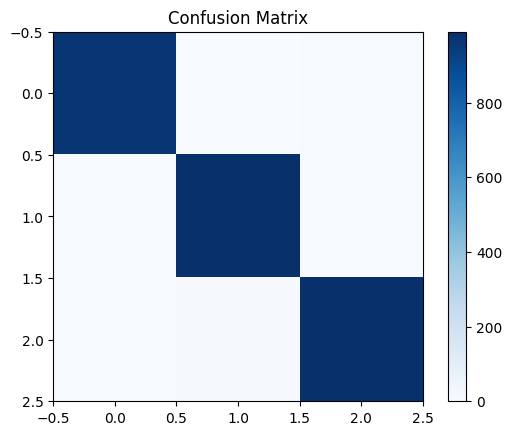


✅ Model saved as 'symptom_cnn_lstm_model.keras'


In [ ]:


# ======================================
# STEP 11: SAVE MODEL + SCALER
# ======================================
model.save("symptom_cnn_lstm_model.keras")
print("\n✅ Model saved as 'symptom_cnn_lstm_model.keras'")

In [ ]:
import joblib

# Save after training
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']